In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [4]:
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [5]:
import torchvision

In [16]:
def create_effnetb2_model(
    num_classes: int=3,
    seed: int=42,
):
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT 
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

In [17]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [19]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [18]:
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [22]:
# Setup DataLoaders
from going_modular import data_setup

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=16
)

In [24]:
from going_modular import engine 

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

set_seeds()
effnetb2_results = engine.train(
    model=effnetb2,
    device=device,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9234 | train_acc: 0.6056 | test_loss: 0.6568 | test_acc: 0.9250
Epoch: 2 | train_loss: 0.6035 | train_acc: 0.8427 | test_loss: 0.4949 | test_acc: 0.9437
Epoch: 3 | train_loss: 0.5102 | train_acc: 0.8685 | test_loss: 0.4008 | test_acc: 0.9437
Epoch: 4 | train_loss: 0.3820 | train_acc: 0.8944 | test_loss: 0.3762 | test_acc: 0.9625
Epoch: 5 | train_loss: 0.3636 | train_acc: 0.9073 | test_loss: 0.3212 | test_acc: 0.9688
Epoch: 6 | train_loss: 0.3653 | train_acc: 0.8987 | test_loss: 0.3074 | test_acc: 0.9458
Epoch: 7 | train_loss: 0.3220 | train_acc: 0.8987 | test_loss: 0.2830 | test_acc: 0.9625
Epoch: 8 | train_loss: 0.3416 | train_acc: 0.8901 | test_loss: 0.2645 | test_acc: 0.9688
Epoch: 9 | train_loss: 0.3040 | train_acc: 0.8966 | test_loss: 0.2622 | test_acc: 0.9563
Epoch: 10 | train_loss: 0.3181 | train_acc: 0.8772 | test_loss: 0.2469 | test_acc: 0.9521


In [25]:
from helper_functions import plot_loss_curves

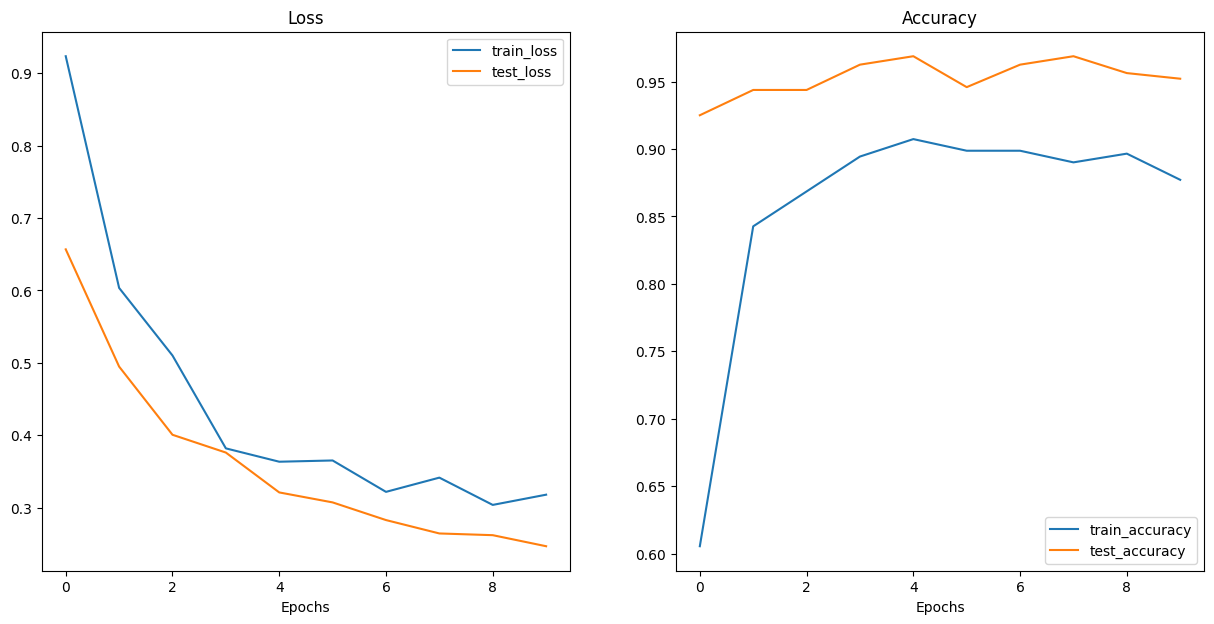

In [26]:
plot_loss_curves(effnetb2_results)